In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nn_fuction
from torchvision import transforms, datasets

In [2]:
# CUDA check
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print("Using pytorch version: ", torch.__version__, ", Device: ", DEVICE)

Using pytorch version:  1.9.0 , Device:  cuda


In [3]:
#hyperparameters
BATCH_SIZE = 32
EPOCH = 10

In [4]:
print(
'''
root: data directory.
train: true-> for training, false: for test
download: download from web?
transform: able to do basic preprocessing. torch.nn input --> ToTensor()
'''
)


root: data directory.
train: true-> for training, false: for test
download: download from web?
transform: able to do basic preprocessing. torch.nn input --> ToTensor()



In [5]:
#Get MNIST dataset

train_dataset = datasets.MNIST(root = "./data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "./data/MNIST",
                               train = False,
                               #download = True,
                               transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)



C:\Users\JWB\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
'''Data size'''
for (x_train, y_train) in train_loader:
    print('X_train:', x_train.size(), 'type:', x_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


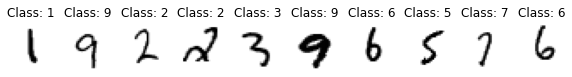

In [7]:

pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(x_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
#MLP custom network
#super():자식클래스에서 부모클래스의 내용을 사용하고 싶은 경우. super().부모클래스내용
#https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch
#view: simillar to reshape in numpy.
#
class CustomNet(nn.Module):
    
    def __init__(self):
        super(CustomNet, self).__init__()
        #self.xsize = 28
        #self.ysize = 28
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        #view parameter -1: All that happens is that the method will do the math for you on how to fill that dimension.
        #For example a.view(2, -1, 4) is equivalent to a.view(2, 2, 4). [16 / (2 x 4) = 2]
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = nn_fuction.sigmoid(x)
        x = self.fc2(x)
        x = nn_fuction.sigmoid(x)
        x = self.fc3(x)
        x = nn_fuction.log_softmax(x, dim = 1)
        
        return x

In [9]:
#set model, optimizer, loss_function

model = CustomNet().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
loss_function = nn.CrossEntropyLoss()

In [10]:

print(model)

CustomNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [11]:
#to method: type conversion
#https://stackoverflow.com/questions/56722169/why-would-we-use-to-method-in-pytorch

def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [12]:
def test_phase(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    #no_grad: locally disable grad. reduce memory consumption
    #https://pytorch.org/docs/stable/generated/torch.no_grad.html?highlight=no_grad#torch.no_grad
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            
            test_loss += loss_function(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            #view_as method https://pytorch.org/docs/stable/generated/torch.Tensor.view_as.html
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
            
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [13]:
#10. MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기
for epoch in range(1, EPOCH + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = test_phase(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

C:\Users\JWB\Anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.364248
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.298926
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 2.319042
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 2.305165
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 2.305377
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 2.279786
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 2.311144
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 2.280309
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 2.213023
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 2.197090

[EPOCH: 1], 	Test Loss: 2.2406, 	Test Accuracy: 30.13 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 2.232447
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 2.195608
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 2.200926
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 2.096843
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 1.955926
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 1.954063
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 1.959880
T